In [1]:
import netgen.occ as occ

import ngsolve as ng
from ngsolve.webgui import Draw
import time
import numpy as np
import matplotlib.pyplot as plt

order = 2

def InductanceForRadius(radius):
    tm = time.monotonic()

    x = 0.75
    y = 0.275

    points = [[ 0.25, 0,    0], [ 0.25, 0.50, 0], [ 0.50, 0.50, 0], [ 0.75, 0,    0],
            [ 0.75, 0.75, 0], [ 0.50, 0,    0], [-0.75, 0.75, 0], [-0.75, 0    ,0],
            [-0.25, 0    ,0], [-0.25, 0.5  ,0], [-0.50, 0.5  ,0], [-0.50, 0    ,0],
            [ 0.75,-0.025,0], [-0.75,-0.025,0], [-0.75,-0.275,0], [ 0.75,-0.275,0],
            [-x, x ,0], [ x, x ,0], [ x,-y ,0], [-x,-y ,0]]

    edges = [[9,10],[10,11],[11,8],[8,9], [2,1],[1,0],[0,5],[5,2], [17,16],[16,19],[19,18],[18,17], [3,7],[7,6],[6,4],[4,3], [15,14],[14,13],[13,12],[12,15], [12,3],[7,13]]
    faces = [[0,1,2,3],[4,5,6,7],[8,9,10,11],[12,13,14,15],[16,17,18,19],[18,20,13,21]]

    e = {}
    for i,j in enumerate(edges): e[i] = occ.Segment(tuple(points[j[0]]),tuple(points[j[1]]))

    f = {}
    for i,j in enumerate(faces): f[i] = occ.Face(occ.Wire([e[j[0]],e[j[1]],e[j[2]],e[j[3]]]))
    # print(f)
    f[6] = occ.Circle((0,0.25), r=radius).Face()#-f[4]-f[3]-f[2]-f[1]-f[0]
    # print(f)

    geo = occ.Glue(list(f.values()))

    geo.faces[0].name = 'coil_plus';  geo.faces[0].col = (1,0.5,0)
    geo.faces[1].name = 'coil_minus'; geo.faces[1].col = (1,0.5,0)
    geo.faces[2].name = 'iron';       geo.faces[2].col = (0,0.5,0)
    geo.faces[3].name = 'air';        geo.faces[3].col = (0,0.5,1)
    geo.faces[4].name = 'iron';       geo.faces[4].col = (0,0.5,0)
    geo.faces[5].name = 'air';        geo.faces[5].col = (0,0.5,1)

    geo.edges[32].name = 'outer'

    area_coil = geo.faces[0].mass
    # print(area_coil)
    inch_to_meter = 1/39.3701

    scale = 1*11
    # solver = "sparsecholesky"
    solver = "pardiso"
    # scale = 0.2*0.9

    h = 0.1*scale
    # hh = 0.01*scale
    hh = 0.1*scale

    geoOCC = occ.OCCGeometry(geo, dim = 2)
    with ng.TaskManager():
        geoOCCmesh = geoOCC.GenerateMesh(maxh = h)
        mesh = ng.Mesh(geoOCCmesh)
    
    J = 66/area_coil
    # s = 58*1e6

    muAir = 1
    muCoil = 1
    muIron = 2500
    pi = 3.14159265359
    mu0 = 4e-7*pi


    # Draw(mesh)


    def ComputePrimal():
        # tm = time.monotonic()
        H1 = ng.H1(mesh = mesh, order = order, dirichlet='outer')
        u,v = H1.TnT()
        
        # sigma = mesh.MaterialCF({"coil_plus": s, "coil_minus": s}, default=1)
        mu = mu0*mesh.MaterialCF({"coil_plus": muCoil, "coil_minus": muCoil, "iron": muIron, "air":muAir}, default=1)
        
        K = ng.BilinearForm(H1)
        K += 1/mu*ng.grad(u)*ng.grad(v)*ng.dx
        
        with ng.TaskManager(): K.Assemble()
        
        coil_plus  =  1 * J * v * ng.dx(definedon = mesh.Materials("coil_plus"))
        coil_minus = -1 * J * v * ng.dx(definedon = mesh.Materials("coil_minus"))
        f = ng.LinearForm(coil_plus + coil_minus).Assemble(); # fnp = f.vec.FV().NumPy()
        
        A = ng.GridFunction(H1)
        
        with ng.TaskManager(): A.vec.data = K.mat.Inverse(H1.FreeDofs(), inverse=solver) * f.vec
        
        B = ng.grad(A)
        H = 1/mu*B

        # print("Primal formulation with %d DOFs took %.4f seconds" % (np.where(H1.FreeDofs())[0].size, time.monotonic()-tm))
        return B,H

    B, H = ComputePrimal()
    # Draw(A,mesh)


    # Duales Problem :

    def ComputeDual():
        # tm = time.monotonic()
        HCurl = ng.HCurl(mesh = mesh, order = order, nograds=True)
        u,v = HCurl.TnT()
        mu = mu0*mesh.MaterialCF({"coil_plus": muCoil, "coil_minus": muCoil, "iron": muIron, "air":muAir}, default=1)
        
        K = ng.BilinearForm(HCurl)
        K += ng.curl(u)*ng.curl(v)*ng.dx + u*v*1e-7*ng.dx
        with ng.TaskManager(): K.Assemble()
        
        coil_plus  =  1 * J * ng.curl(v) * ng.dx(definedon = mesh.Materials("coil_plus"))
        coil_minus = -1 * J * ng.curl(v) * ng.dx(definedon = mesh.Materials("coil_minus"))
        f = ng.LinearForm(coil_plus + coil_minus).Assemble(); # fnp = f.vec.FV().NumPy()
        
        
        import scipy.sparse as sp
        import matplotlib.pyplot as plt
        rows,cols,vals = K.mat.COO()
        A = sp.csr_matrix((vals,(rows,cols)))
        # plt.spy(A,markersize=1)
        
        Hj = ng.GridFunction(HCurl)
        with ng.TaskManager(): Hj.vec.data = K.mat.Inverse(HCurl.FreeDofs(), inverse=solver) * f.vec
        # Draw(Hj,mesh)
        
        H1 = ng.H1(mesh = mesh, order = order)
        u,v = H1.TnT()
        
        K = ng.BilinearForm(H1)
        K += mu*ng.grad(u)*ng.grad(v)*ng.dx
        with ng.TaskManager(): K.Assemble()
        
        f = ng.LinearForm(-mu*(Hj*ng.grad(v))*ng.dx).Assemble()
        
        psi = ng.GridFunction(H1)
        with ng.TaskManager(): psi.vec.data = K.mat.Inverse(H1.FreeDofs(), inverse=solver) * f.vec
        
        BD = mu*(ng.grad(psi)+Hj)
        # Draw(BD,mesh)
        # print("Dual formulation with %d DOFs (Hj) and %d DOFs (pot) took %.4f seconds" % (np.where(HCurl.FreeDofs())[0].size, np.where(H1.FreeDofs())[0].size, time.monotonic()-tm))
        return BD

    BD = ComputeDual()
    # Draw(B,mesh)
    # Draw(BD,mesh)

    iter = 10

    EnergyInductance = np.zeros(iter)
    CoenergyInductance = np.zeros(iter)
    dofs = np.zeros(iter)

    for i in range(iter):
        B, H = ComputePrimal()
        BD = ComputeDual()
        
        dofs[i] = mesh.ne
        #############################################################################################################
        mu = mu0*mesh.MaterialCF({"coil_plus": muCoil, "coil_minus": muCoil, "iron": muIron, "air":muAir}, default=1)
        Energy = 1/2*ng.Integrate(1/mu*B*B, mesh)
        EnergyInductance[i] = 1*inch_to_meter*2*Energy*1000
        # print("  Energy approach : L = %.6f" % EnergyInductance[i], "mH")
        
        CoEnergy = 1/2*ng.Integrate(1/mu*BD*BD, mesh)
        CoenergyInductance[i] = 1*inch_to_meter*2*CoEnergy*1000
        # print("Coenergy approach : L = %.6f" % CoenergyInductance[i], "mH")
        #############################################################################################################

        elerr = ng.Integrate(1/mu*(B-BD)*(B-BD), mesh, ng.VOL, element_wise=True)
        maxerr = max(elerr)
        # plt.plot(np.sort(elerr))

        elerrNP = elerr.NumPy()
        a = np.argsort(elerrNP)
        sorted_elerrNP = elerrNP[a]
        
        procentage = (1-0.7071)
        total_error = np.sum(elerrNP)
        cum_sum_error = np.cumsum(sorted_elerrNP)
        indices = np.where(cum_sum_error>procentage*total_error)[0]
        mapped_indices = a[indices]
        
        if i!=iter-1:
            # print("Max. error: ", maxerr, "\n")
            for el in mesh.Elements():
                # mesh.SetRefinementFlag(el, elerr[el.nr] > 0.25*maxerr)
                mesh.SetRefinementFlag(el, el.nr in mapped_indices)
            mesh.Refine()
            print(i,iter-2,". New mesh elements : #", mesh.nv)

    # B, H = ComputePrimal()
    # BD = ComputeDual()
    
    print("Total time for a single simulation: %.4f seconds" % (time.monotonic()-tm))
    
    return (CoenergyInductance[-1]+EnergyInductance[-1])/2, np.abs(CoenergyInductance[-1]-EnergyInductance[-1])

In [2]:
radi = 2**(np.arange(8)+1)

ind = np.zeros(radi.size)
indmaxerr = np.zeros(radi.size)

for i in range(radi.size):
    print(i,"\n")
    a,b = InductanceForRadius(radi[i])
    print(a,b)
    ind[i] = a
    indmaxerr[i] = b

0 

0 8 . New mesh elements : # 290
1 8 . New mesh elements : # 458
2 8 . New mesh elements : # 841
3 8 . New mesh elements : # 1837
4 8 . New mesh elements : # 4672
5 8 . New mesh elements : # 13148
6 8 . New mesh elements : # 35422
7 8 . New mesh elements : # 91866
8 8 . New mesh elements : # 246761
Total time for a single simulation: 38.7190 seconds
1.7812401125322954 7.223942210199397e-05
1 

0 8 . New mesh elements : # 345
1 8 . New mesh elements : # 513
2 8 . New mesh elements : # 939
3 8 . New mesh elements : # 2005
4 8 . New mesh elements : # 5008
5 8 . New mesh elements : # 14023
6 8 . New mesh elements : # 39578
7 8 . New mesh elements : # 104337
8 8 . New mesh elements : # 274568
Total time for a single simulation: 44.1880 seconds
1.7879282978236115 5.6420287438685435e-05
2 

0 8 . New mesh elements : # 546
1 8 . New mesh elements : # 717
2 8 . New mesh elements : # 1119
3 8 . New mesh elements : # 2127
4 8 . New mesh elements : # 4979
5 8 . New mesh elements : # 13680
6 8 .

In [3]:
ind

array([1.78124011, 1.7879283 , 1.78971174, 1.79016437, 1.79027855,
       1.79030748, 1.79031318, 1.79031416])

In [4]:
radi

array([  2,   4,   8,  16,  32,  64, 128, 256], dtype=int32)

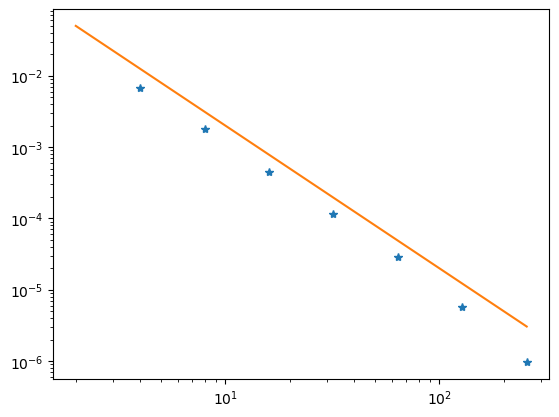

In [5]:
plt.loglog(radi[1:],ind[1:]-ind[:-1],'*')
plt.loglog(radi,0.2/radi**2)
# plt.loglog(radi,indmaxerr,'.')

In [7]:
radi = 2**(np.arange(8)+1)
print(radi)

[  2   4   8  16  32  64 128 256]
